In [1]:

import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from simulate import SimulationDataset  
import jax
from jax import jit, vmap, grad, random, value_and_grad
import jax.numpy as jnp


### Set device

In [2]:
seed = 0
# random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using MPS (Apple Silicon)


### Define the parameters for the simulation

In [3]:
ns = 10000
sim = 'r1'
n = 4
dim = 2
nt = 1000
dt = 5e-3

### Generate the dataset and see the shape

In [4]:
import simulate
from simulate import SimulationDataset
simulation = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
simulation.simulate(ns)

In [5]:
simulation.data.shape

(10000, 500, 4, 6)

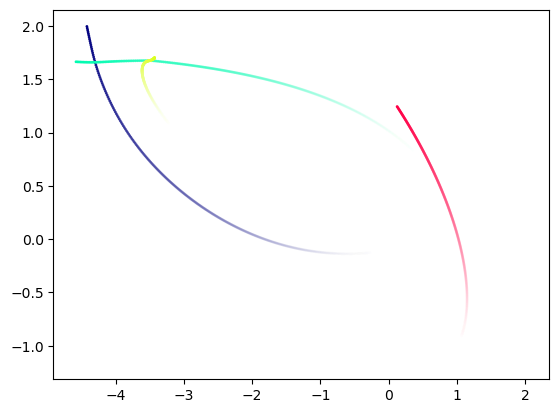

In [6]:
simulation.plot(0, animate=True, plot_size=False)

### Split the data and put into dataloader

In [7]:
accel_data = simulation.get_acceleration()

# Convert simulation and acceleration data directly to tensors
X = torch.tensor(np.array(simulation.data), dtype=torch.float32)  # Shape: (num_samples, num_time_steps, num_particles, num_features)
Y = torch.tensor(np.array(accel_data), dtype=torch.float32)       # Shape: (num_samples, num_time_steps, num_particles, output_dim)

# Select every 5th timestep along time dimension
X = X[:, ::5].reshape(-1, X.shape[2], X.shape[3])  # Flatten sample & time dims
Y = Y[:, ::5].reshape(-1, Y.shape[2], Y.shape[3])  # Flatten sample & time dims

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

In [8]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

torch.Size([750000, 4, 6]) torch.Size([250000, 4, 6]) torch.Size([750000, 4, 2]) torch.Size([250000, 4, 2])


In [9]:
from models import NbodyGNN,get_edge_index

edge_index = get_edge_index(n, sim)


from torch_geometric.data import Data, DataLoader

train_data_list = [
    Data(
        x=X_train[i],  
        edge_index=edge_index,  
        y=Y_train[i]
    ) for i in range(len(Y_train))
]

test_indices = np.random.choice(len(X_test), size=1024, replace=False)  # Randomly select 1024 indices from the test set
test_data_list = [
    Data(
        x=X_test[i],  
        edge_index=edge_index,  
        y=Y_test[i]
    ) for i in test_indices
]



batch = 64

trainloader = DataLoader(train_data_list, batch_size=batch, shuffle=True)
testloader = DataLoader(test_data_list, batch_size=1024, shuffle=False)


/Users/liuyihao/Desktop/yl2063/src/models.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Standard model

In [10]:
aggr = 'add'
hidden = 300
msg_dim = 100
n_f = simulation.data.shape[3]

In [11]:
from torch.optim.lr_scheduler import OneCycleLR
initial_learing_rate = 1e-3


total_epochs = 30


batch_per_epoch = len(trainloader)


batch_per_epoch

11719

In [12]:

model_standard = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_standard = torch.optim.Adam(model_standard.parameters(), lr=initial_learing_rate, weight_decay=1e-8)


sched_standard = OneCycleLR(opt_standard, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [13]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-r1-standard", reinit=True)

for epoch in range(total_epochs):
    model_standard.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_standard.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_standard.loss(batch)
        loss.backward()
        opt_standard.step()
        sched_standard.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 10.800268
Epoch 2/30, Loss: 6.274224
Epoch 3/30, Loss: 5.543810
Epoch 4/30, Loss: 4.866014
Epoch 5/30, Loss: 4.338009
Epoch 6/30, Loss: 4.089678
Epoch 7/30, Loss: 3.760186
Epoch 8/30, Loss: 3.589683
Epoch 9/30, Loss: 3.276603
Epoch 10/30, Loss: 3.135407
Epoch 11/30, Loss: 2.939247
Epoch 12/30, Loss: 2.849506
Epoch 13/30, Loss: 2.721840
Epoch 14/30, Loss: 2.584886
Epoch 15/30, Loss: 2.391757
Epoch 16/30, Loss: 2.327558
Epoch 17/30, Loss: 2.122341
Epoch 18/30, Loss: 2.007386
Epoch 19/30, Loss: 1.824513
Epoch 20/30, Loss: 1.650706
Epoch 21/30, Loss: 1.521443
Epoch 22/30, Loss: 1.364334
Epoch 23/30, Loss: 1.127706
Epoch 24/30, Loss: 0.947124
Epoch 25/30, Loss: 0.812294
Epoch 26/30, Loss: 0.640001
Epoch 27/30, Loss: 0.507390
Epoch 28/30, Loss: 0.418695
Epoch 29/30, Loss: 0.355159
Epoch 30/30, Loss: 0.329153


In [14]:
# Save the model state
import os

root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r1_standard.pth")

torch.save(model_standard.state_dict(), save_path)

In [15]:
import os
model_standard = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r1_standard.pth")
state_dict = torch.load(save_path, map_location=device)
model_standard.load_state_dict(state_dict)


model_standard.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_23048/3986128128.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

NbodyGNN()

In [15]:
model_standard.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_standard(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.039674


Selected channels: ['msg95', 'msg24']


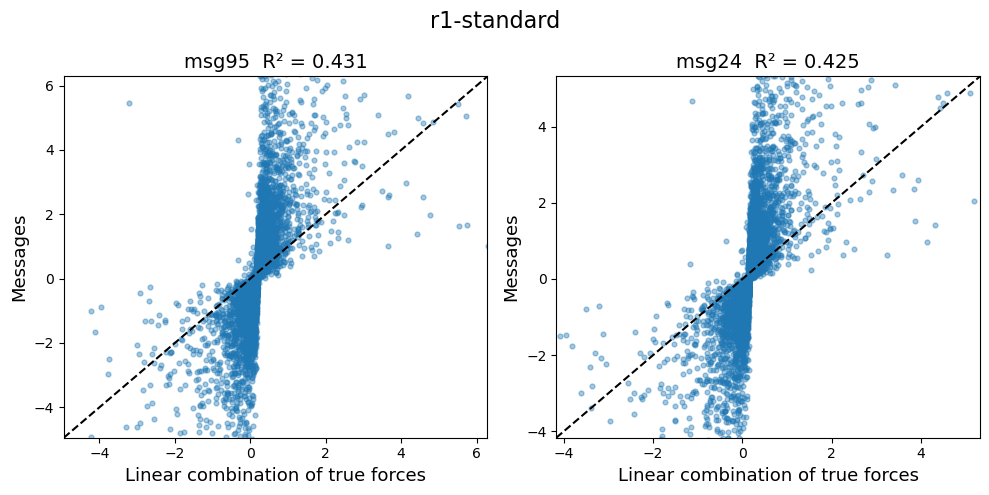

In [53]:

from message_processing import measure_latent, fit_multioutput_force
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Measure latent variables
latent_df_standard = measure_latent(model_standard, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_standard['fx_true'] = (latent_df_standard['m1'] * latent_df_standard['m2']) * \
                    (latent_df_standard['dx'] / (latent_df_standard['r'] ** 2 + 1e-6))
latent_df_standard['fy_true'] = (latent_df_standard['m1'] * latent_df_standard['m2']) * \
                    (latent_df_standard['dy'] / (latent_df_standard['r'] ** 2 + 1e-6))

# Fit multi-output linear regression to find top channels
lr, top_channels= fit_multioutput_force(latent_df_standard, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_standard[['fx_true','fy_true']].values

# True messages
Messages = latent_df_standard[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("r1-standard", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()


In [54]:
import pysr
sr_standard= pysr.PySRRegressor(
  niterations=100,
  binary_operators=["+", "-", "*", "/","^"],
  run_id="r1-standard",
  random_state=seed,
  parallelism="serial",
)
df_sub_standard = latent_df_standard[['dx','dy','r','m1','m2', top_channels[0]]].sample(5000)
X = df_sub_standard[['dx','dy','r','m1','m2']].values
Y = df_sub_standard[top_channels[0]].values
sr_standard.fit(X, Y)
print(sr_standard)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:89: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.430e+04
Progress: 174 / 3100 total iterations (5.613%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.333e+01  1.594e+01  y = 0.16334
3           2.205e+01  2.821e-02  y = x₀ / x₂
5           1.431e+01  2.160e-01  y = (x₀ / x₂) / x₂
7           1.386e+01  1.617e-02  y = ((x₀ / x₂) / x₂) / 0.78098
9           4.629e+00  5.482e-01  y = (x₀ * ((x₄ / x₂) / x₂)) * 0.39444
11          4.618e+00  1.292e-03  y = ((((x₀ * x₄) / x₂) / x₂) - -0.27705) * 0.39431
13          1.601e+00  5.295e-01  y = ((1.0911 / x₂) ^ 0.70055) * ((x₄ * (x₀ / x₂)) + 0.1007...
                                      6)
15          1.601e+00  2.390e-05  y = (((0.79544 / x₂) ^ 0.69943) * 1.2522) * (((x₄ * x₀) / ...
                                      x₂) + 0.10399)
17         

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.410e+04
Progress: 2350 / 3100 total iterations (75.806%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.333e+01  1.594e+01  y = 0.16334
3           2.205e+01  2.821e-02  y = x₀ / x₂
5           1.420e+01  2.200e-01  y = x₀ / (x₂ ^ 2.0341)
7           1.645e+00  1.078e+00  y = (x₄ * x₀) / (x₂ ^ 1.721)
9           1.235e+00  1.433e-01  y = (x₀ * (x₄ / x₂)) / (x₂ - -0.049064)
11          5.952e-01  3.650e-01  y = x₄ * (((x₀ / x₂) + 0.13017) / (x₂ - -0.049728))
13          5.425e-01  4.637e-02  y = x₄ * (((x₀ / (x₂ + 0.022726)) + 0.11853) / (x₂ - -0.01...
                                      6888))
15          3.415e-01  2.314e-01  y = (((((x₁ * -0.13712) + x₀) / x₂) + 0.12983) * x₄) / (x₂...
                                       - -0.051108)
1

### Bottleneck model

In [19]:

msg_dim_bottleneck=2

model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_bottleneck = torch.optim.Adam(model_bottleneck.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_bottleneck = OneCycleLR(opt_bottleneck, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)


In [20]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-r1-bottleneck", reinit=True)
for epoch in range(total_epochs):
    model_bottleneck.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_bottleneck.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_bottleneck.loss(batch)
        loss.backward()
        opt_bottleneck.step()
        sched_bottleneck.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,30
train_loss,0.32915


Epoch 1/30, Loss: 9.784272
Epoch 2/30, Loss: 5.411694
Epoch 3/30, Loss: 4.570436
Epoch 4/30, Loss: 4.028833
Epoch 5/30, Loss: 3.606935
Epoch 6/30, Loss: 3.280692
Epoch 7/30, Loss: 3.100733
Epoch 8/30, Loss: 3.008563
Epoch 9/30, Loss: 2.959202
Epoch 10/30, Loss: 2.824986
Epoch 11/30, Loss: 2.669022
Epoch 12/30, Loss: 2.542361
Epoch 13/30, Loss: 2.420278
Epoch 14/30, Loss: 2.308591
Epoch 15/30, Loss: 2.253568
Epoch 16/30, Loss: 2.062237
Epoch 17/30, Loss: 1.886446
Epoch 18/30, Loss: 1.823796
Epoch 19/30, Loss: 1.623585
Epoch 20/30, Loss: 1.481964
Epoch 21/30, Loss: 1.357478
Epoch 22/30, Loss: 1.205931
Epoch 23/30, Loss: 0.994028
Epoch 24/30, Loss: 0.867794
Epoch 25/30, Loss: 0.740271
Epoch 26/30, Loss: 0.578006
Epoch 27/30, Loss: 0.465031
Epoch 28/30, Loss: 0.381992
Epoch 29/30, Loss: 0.328853
Epoch 30/30, Loss: 0.304697


In [21]:
import os


root_checkpoints = os.path.join("..", "model_weights")

os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r1_bottleneck.pth")

torch.save(model_bottleneck.state_dict(), save_path)

In [22]:
model_bottleneck.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_bottleneck(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.034219


Selected channels: ['msg1', 'msg0']


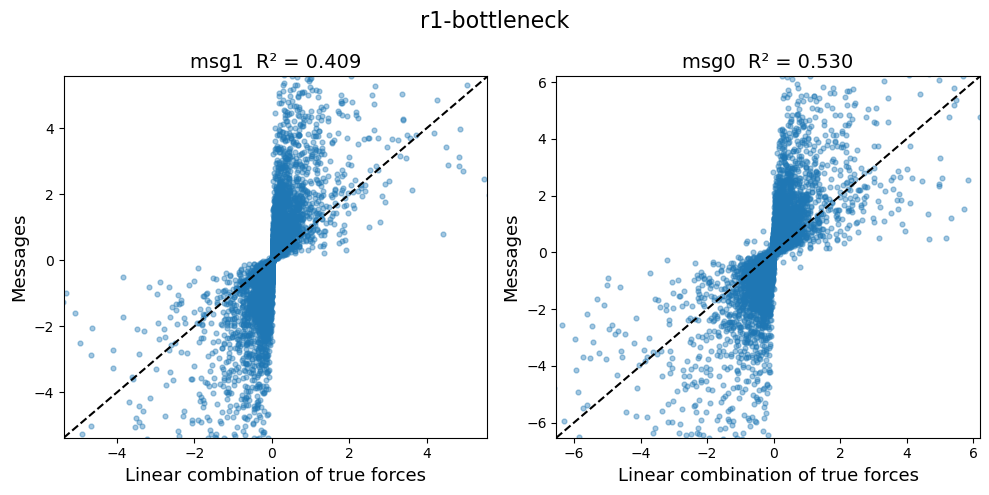

In [55]:
from message_processing import measure_latent, fit_multioutput_force
from sklearn.metrics import r2_score


# Measure latent variables
latent_df_bottleneck = measure_latent(model_bottleneck, testloader, device=device, dim=dim, msg_dim=msg_dim_bottleneck)

# compute true force components and add them to latent_df
latent_df_bottleneck['fx_true'] = -(latent_df_bottleneck['m1'] * latent_df_bottleneck['m2']) * \
                    (latent_df_bottleneck['dx'] / (latent_df_bottleneck['r'] ** 2 + 1e-6))
latent_df_bottleneck['fy_true'] = -(latent_df_bottleneck['m1'] * latent_df_bottleneck['m2']) * \
                    (latent_df_bottleneck['dy'] / (latent_df_bottleneck['r'] ** 2 + 1e-6))

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_bottleneck, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_bottleneck[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_bottleneck[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("r1-bottleneck", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()

In [56]:
import pysr
sr_bottleneck = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/", "^"],
    # unary_operators=["square"],
    run_id="r1-bottleneck",
    random_state=seed,
    parallelism="serial",
)
df_sub_bottleneck = latent_df_bottleneck[['dx', 'dy', 'r', 'm1','m2', top_channels[1]]].sample(5000)
X = df_sub_bottleneck[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_bottleneck[top_channels[1]].values
sr_bottleneck.fit(X, Y)
print(sr_bottleneck)



/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:89: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.340e+04
Progress: 203 / 3100 total iterations (6.548%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.852e+01  1.594e+01  y = -0.072972
3           2.473e+01  7.128e-02  y = -0.54898 / x₂
5           2.432e+01  8.352e-03  y = (-0.61556 / x₂) - -0.68235
7           1.789e+01  1.535e-01  y = (x₀ / (x₂ * x₂)) * -1.6164
9           9.045e+00  3.411e-01  y = (x₀ / (x₂ * (x₂ / -0.45536))) * x₄
11          9.045e+00  -0.000e+00  y = ((x₄ * x₀) / ((x₂ * x₂) * -2.0122)) / 1.0914
13          1.417e+00  9.267e-01  y = ((((x₁ * -0.65043) - x₀) / x₂) * x₄) / (x₂ / 0.449)
15          5.573e-02  1.618e+00  y = ((((x₁ * -0.9077) - x₀) * x₄) / (x₂ / 0.59171)) / (x₂ ...
                                      - -0.010987)
17          1.905e-02  5.367e-01  y = ((

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        -0.07437997   
	1         0.071282                                    -0.5489793 / x2   
	2         0.040257                           (-0.003304561 / x1) / x2   
	3         0.253863                    x0 / (x2 * (0.0090154065 - x2))   
	4         0.254876      (-0.015557011 - (x0 * x4)) / (x2 ^ 1.7453943)   
	5         1.280286  ((x1 / -1.2792373) - x0) * (x4 / (x2 ^ 1.763054))   
	6         0.570228  ((x1 / -1.2062131) - x0) * ((x4 * 0.7494708) /...   
	7         2.015464  (x4 / (x2 / 0.59481066)) * (((x1 * -0.9053964)...   
	8         0.048142  ((((x1 * -0.9053964) - x0) / (x2 - -0.00970359...   
	9   >>>>  0.231818  (x4 / (x2 - -0.0097681945)) * ((((x1 * -0.8991...   
	10        0.095452  ((x4 * ((((x1 * -0.899178) - x0) / (x2 / 0.603...   
	11        0.008880  ((x4 * ((((x1 * -0.899178) - x0) / (x2 / 0.603...   
	12      

### L1 regularization model

In [27]:
model_l1 = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)

opt_l1 = torch.optim.Adam(model_l1.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_l1 = OneCycleLR(opt_l1, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [28]:
wandb.init(project="DIS-final-pro", name="Train-r1-l1", reinit=True)
for epoch in range(total_epochs):
    model_l1.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_l1.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_l1.loss(batch)
        loss.backward()
        opt_l1.step()
        sched_l1.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,30
train_loss,0.3047


Epoch 1/30, Loss: 17.711968
Epoch 2/30, Loss: 7.498118
Epoch 3/30, Loss: 6.645768
Epoch 4/30, Loss: 5.939681
Epoch 5/30, Loss: 5.338790
Epoch 6/30, Loss: 4.702517
Epoch 7/30, Loss: 4.269262
Epoch 8/30, Loss: 3.923747
Epoch 9/30, Loss: 3.707597
Epoch 10/30, Loss: 3.665322
Epoch 11/30, Loss: 3.441050
Epoch 12/30, Loss: 3.309570
Epoch 13/30, Loss: 3.220967
Epoch 14/30, Loss: 3.077254
Epoch 15/30, Loss: 2.809084
Epoch 16/30, Loss: 2.744909
Epoch 17/30, Loss: 2.693266
Epoch 18/30, Loss: 2.448031
Epoch 19/30, Loss: 2.309666
Epoch 20/30, Loss: 2.069203
Epoch 21/30, Loss: 1.902644
Epoch 22/30, Loss: 1.741078
Epoch 23/30, Loss: 1.525114
Epoch 24/30, Loss: 1.340214
Epoch 25/30, Loss: 1.143124
Epoch 26/30, Loss: 0.960263
Epoch 27/30, Loss: 0.828218
Epoch 28/30, Loss: 0.713580
Epoch 29/30, Loss: 0.649449
Epoch 30/30, Loss: 0.618869


In [29]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r1_l1.pth")

torch.save(model_l1.state_dict(), save_path)

In [30]:
model_l1.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_l1(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.067928


Selected channels: ['msg85', 'msg27']


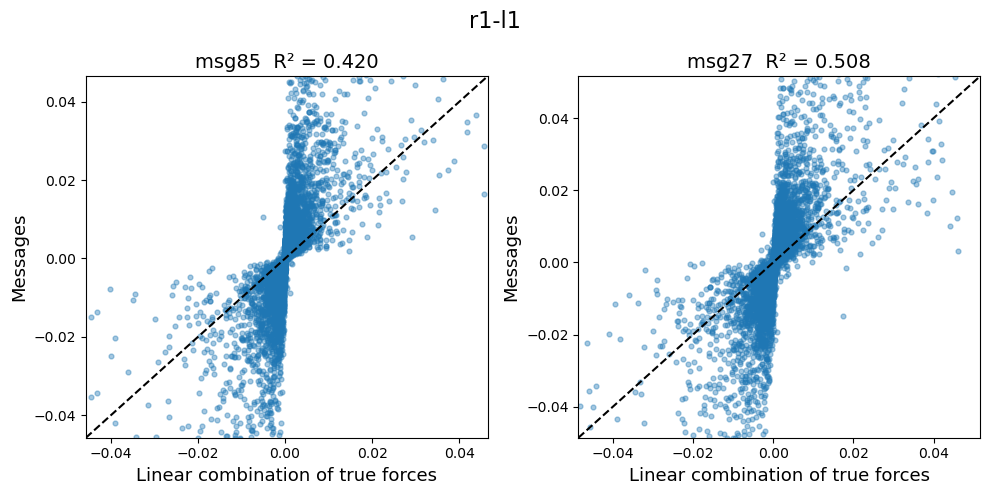

In [57]:
# Measure latent variables
latent_df_l1 = measure_latent(model_l1, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_l1['fx_true'] = (latent_df_l1['m1'] * latent_df_l1['m2']) * \
                    (latent_df_l1['dx'] / (latent_df_l1['r'] ** 2 + 1e-6))
latent_df_l1['fy_true'] = (latent_df_l1['m1'] * latent_df_l1['m2']) * \
                    (latent_df_l1['dy'] / (latent_df_l1['r'] ** 2 + 1e-6))


# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_l1, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_l1[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_l1[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("r1-l1", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()


In [58]:
import pysr
sr_l1 = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/", "^"],
    # unary_operators=["square"],
    run_id="r1-l1",
    random_state=seed,
    parallelism="serial",
)
df_sub_l1 = latent_df_l1[['dx', 'dy', 'r', 'm1','m2',top_channels[1]]].sample(5000)
X = df_sub_l1[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_l1[top_channels[1]].values
sr_l1.fit(X, Y)
print(sr_l1)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:89: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.540e+04
Progress: 197 / 3100 total iterations (6.355%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.910e-03  1.594e+01  y = 0.00039183
3           1.864e-03  1.213e-02  y = 0.0019953 / x₂
5           1.574e-03  8.449e-02  y = (6.4399e-05 / x₂) / x₀
7           1.132e-03  1.649e-01  y = ((x₀ / x₂) * 0.010572) / x₂
9           1.132e-03  -0.000e+00  y = (((x₀ / x₂) * -0.096999) / x₂) * -0.10899
11          2.844e-04  6.907e-01  y = ((x₀ * ((0.0014763 / x₂) * x₄)) / x₂) / 0.37545
13          2.708e-04  2.447e-02  y = ((x₀ / x₂) * 0.0060804) * ((x₄ ^ 1.1249) / (x₂ + x₂))
15          1.963e-04  1.609e-01  y = (((((x₀ * 1.0654) * x₄) * 0.045011) / x₂) * -0.11771) ...
                                      / (-0.011282 - x₂)
19          1.963e-04  

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.910e-03  1.594e+01  y = 0.00039183
3           1.864e-03  1.213e-02  y = 0.0019953 / x₂
5           1.574e-03  8.449e-02  y = (6.4399e-05 / x₂) / x₀
7           1.003e-03  2.252e-01  y = (0.00033589 ^ x₂) * (x₀ * x₄)
9           2.844e-04  6.304e-01  y = (((x₀ / x₂) * 0.003932) / x₂) * x₄
11          1.962e-04  1.855e-01  y = ((x₄ / (-0.011098 - x₂)) * -0.0056109) * (x₀ / x₂)
13          7.497e-05  4.812e-01  y = ((x₄ * ((x₁ + x₀) / (-0.024264 - x₂))) / x₂) * -0.0057...
                                      576
15          1.624e-05  7.647e-01  y = (x₄ / (-0.024272 - x₂)) * (-0.006537 * (((x₁ * 0.60506...
                                      ) + x₀) / x₂))
17          1.242e-05  1.342e-01  y = (((x₀ + (x₁ * 0.6314)) / (-0.0076293 - x₂)) * 0.006363...
                                      6) * (x₄ / (-0.011079 - x₂))
19          6.

### KL divergence model

In [41]:
from models import VariationNbody

In [42]:
model_kl = VariationNbody(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), beta=1.0).to(device)

opt_kl = torch.optim.Adam(model_kl.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_kl = OneCycleLR(opt_kl, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [43]:
import wandb
wandb.init(project="DIS-final-pro-kl", name="Train-r1", reinit=True)
for epoch in range(total_epochs):
    model_kl.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_kl.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_kl.loss(batch)
        loss.backward()
        opt_kl.step()
        sched_kl.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.61887


Epoch 1/30, Loss: 3.155940
Epoch 2/30, Loss: 3.071357
Epoch 3/30, Loss: 2.989683
Epoch 4/30, Loss: 2.966602
Epoch 5/30, Loss: 2.857015
Epoch 6/30, Loss: 2.779834
Epoch 7/30, Loss: 2.758724
Epoch 8/30, Loss: 2.743997
Epoch 9/30, Loss: 2.728866
Epoch 10/30, Loss: 2.716395
Epoch 11/30, Loss: 2.697701
Epoch 12/30, Loss: 2.685004
Epoch 13/30, Loss: 2.674069
Epoch 14/30, Loss: 2.657851
Epoch 15/30, Loss: 2.648616
Epoch 16/30, Loss: 2.632361
Epoch 17/30, Loss: 2.618003
Epoch 18/30, Loss: 2.606118
Epoch 19/30, Loss: 2.594154
Epoch 20/30, Loss: 2.576343
Epoch 21/30, Loss: 2.561476
Epoch 22/30, Loss: 2.546462
Epoch 23/30, Loss: 2.527108
Epoch 24/30, Loss: 2.507994
Epoch 25/30, Loss: 2.497280
Epoch 26/30, Loss: 2.479062
Epoch 27/30, Loss: 2.466869
Epoch 28/30, Loss: 2.456639
Epoch 29/30, Loss: 2.453074
Epoch 30/30, Loss: 2.449426


In [44]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r1_kl.pth")

torch.save(model_kl.state_dict(), save_path)

In [45]:
model_kl.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_kl(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 1.994920


Top μ channels: ['mu63', 'mu49']
Multi-output μ‐linear fit R² = 0.3465


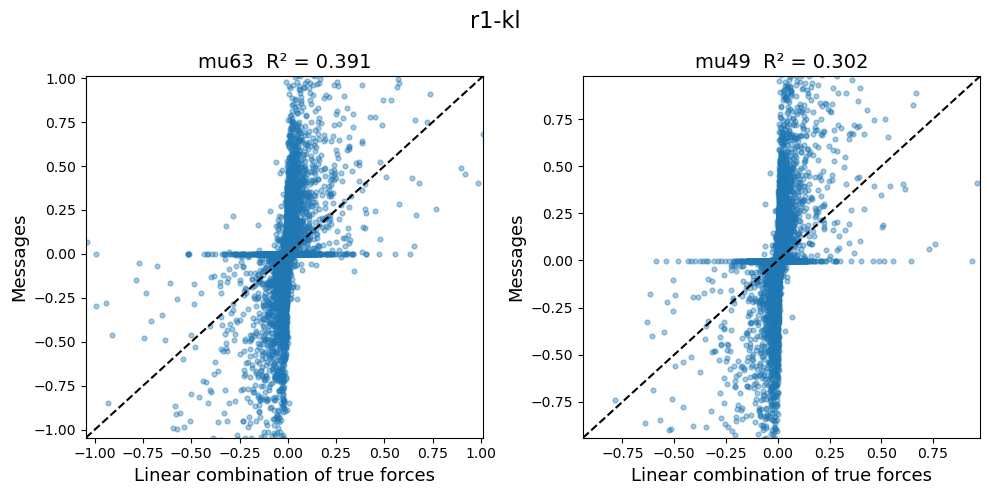

In [61]:
from message_processing import measure_variational_latent
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score   

df = measure_variational_latent(
    model_kl, testloader, device=device,
    dim=dim, msg_dim=msg_dim
)

# Select dim dimensions with largest variance
mu_cols = [c for c in df.columns if c.startswith("mu")]
top_mu  = df[mu_cols].std().nlargest(dim).index.tolist()
print("Top μ channels:", top_mu)

# Compute true force components
df['fx_true'] = (df['m1'] * df['m2']) * (df['dx'] / (df['r'] ** 2 + 1e-6))
df['fy_true'] = (df['m1'] * df['m2']) * (df['dy'] / (df['r'] ** 2 + 1e-6))


Xs = df[['fx_true','fy_true']].values       # (N,2)
Ysm   = df[top_mu].values                     # (N,dim)

# fit 
lr_mu = LinearRegression().fit(Xs, Ysm)
r2_mu = lr_mu.score(Xs, Ysm)
print(f"Multi-output μ‐linear fit R² = {r2_mu:.4f}")
# Predicted message value using the linear regression model from the force
Predicted_messages = lr_mu.predict(Xs)

fig, axes = plt.subplots(1, dim, figsize=(10, 5))
fig.suptitle("r1-kl", fontsize=16)

for idx, ch in enumerate(top_mu):
    y_true_ch = Ysm[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()

In [60]:

import pysr
sr_kl = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/", "^"],
    # unary_operators=["square"],
    run_id="r1-kl",
    random_state=seed,
    parallelism="serial",
)
df_sub_kl = df[['dx', 'dy', 'r', 'm1','m2',top_mu[0]]].sample(5000)

X = df_sub_kl[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_kl[top_mu[0]].values
sr_kl.fit(X, Y)
print(sr_kl)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:89: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.660e+04
Progress: 243 / 3100 total iterations (7.839%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.014e-01  1.594e+01  y = 0.0013845
3           2.989e-01  4.164e-03  y = x₀ * -0.032521
5           2.777e-01  3.682e-02  y = x₀ * (-0.21769 / x₂)
7           2.156e-01  1.265e-01  y = (x₀ * (-0.13874 / x₂)) / x₂
9           1.299e-01  2.533e-01  y = (((x₄ / x₂) * x₀) / x₂) * -0.059382
11          1.210e-01  3.562e-02  y = ((-0.044803 / (x₂ / x₄)) / x₂) * (x₀ + x₁)
13          8.881e-02  1.547e-01  y = ((((x₀ + x₁) * x₄) * -0.076455) / (x₂ + 0.026966)) / x...
                                      ₂
15          8.879e-02  1.148e-04  y = x₄ * (((0.52586 / (x₂ + 0.02625)) * (-0.14617 / x₂)) *...
                                       (x₀ + x₁))
1

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.014e-01  1.594e+01  y = 0.0013253
3           2.989e-01  4.164e-03  y = x₀ * -0.032521
5           2.777e-01  3.682e-02  y = x₀ * (-0.21769 / x₂)
7           2.029e-01  1.570e-01  y = x₀ * (-0.25967 / (x₂ ^ 1.796))
9           1.246e-01  2.437e-01  y = ((x₄ / (x₂ ^ 1.8055)) * x₀) * -0.095457
11          9.626e-02  1.291e-01  y = (x₄ * ((x₁ + x₀) / (x₂ ^ 1.7652))) * -0.092374
13          8.436e-02  6.598e-02  y = ((((x₀ + x₁) * x₄) + x₀) / (x₂ ^ 1.7792)) * -0.081832
15          7.742e-02  4.295e-02  y = (((x₀ + (x₄ * (x₀ + x₁))) / (x₂ + 0.024989)) / x₂) * -...
                                      0.069137
17          7.455e-02  1.889e-02  y = ((x₀ + (x₁ / 3.7763)) / x₂) * ((0.82444 - (x₄ ^ 0.2234...
                                      9)) / (x₂ ^ 0.85686))
19          6.413e-02  7.527e-02  y = ((((x₁ / 1.9161) + x₀) * ((0.51357 -